# What's an autoencoder?

An autoencoder is a machine learning system that takes an input and attempts to produce output that matches the input as closely as possible.  This useless and simple task doesn't seem to warrant the attention of machine learning (for example, a function that returns its input is a perfect "autoencoder"), but the point of an autoencoder is the journey, not the destination.  Typically, restrictions are placed on the autoencoder so that in the course of training, some other objective is achieved.

![ae flowchart](https://alanbertl.com/wp-content/uploads/2018/12/AE.png)

An autoencoder consists of two components, an encoder and a decoder.  Between them sits the code layer, which isn't so much a component unto itself as the format of the output of the encoder after processing its input.  

As an example of a useful task for an autoencoder, suppose we make the code layer small in memory compared to the input size.  We then train the autoencoder over a dataset to encode the inputs into this small memory space, and then reconstruct them as best it can with the decoder.  If the autoencoder is successful and is able to generalize beyond the dataset, voila, we've created a compression algorithm for that class of data.

Other objectives might be feature extraction at the code layer, repurposing the pretrained the encoder/decoder for some other task, denoising, etc.

# MNIST Autoencoder using fast.ai 1.0

A few months ago I created an autoencoder for the MNIST dataset using the old version of the free [fast.ai](https://www.fast.ai/) Python machine learning library used in their online [deep learning class](https://course.fast.ai/).  I did it for several reasons: I'd recently learned about autoencoders and wanted to implement one, I wanted to use something like an autoencoder for a project I was working on, and I wanted to get a better feel for [PyTorch](https://pytorch.org/) and the fast.ai library.

I've been wanting to do a blog post with a simple autoencoder implementation, and instead of just pruning the notebook I already had, I've decided to update it to the latest version of fast.ai.  This is for my benefit since working through the online class I've exclusively been using the old version.

This post gives the full Python code for implementing the autoencoder using the fast.ai library (and is downloadable as a [Jupyter notebook](https://jupyter.org/)).  A familiarity with Python is helpful to read the code, and although I try to briefly describe what's happening throughout, a familiarity with deep learning is assumed.  I'll also periodically refer to features in the old version of fast.ai's library to describe what I learned about the new version.

# Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

The fast.ai library sits on top of PyTorch, an open-source machine learning library for Python.

Version 1.0 splits the highest levels of the library into four implementation packages, `fastai.vision` (for image applications), `fastai.text` (for language procession), `fastai.tabular` (for tabular/structured data), and `fastai.collab` (for collaborative filtering).  I worked with MNIST data so `fastai.vision` is what we want.

In [2]:
from fastai.imports import *
from fastai.vision import *
from fastai.data_block import *
from fastai.basic_train import *

import pandas as pd

I used a GPU.  I haven't made allowances in this code for cases where a GPU isn't available, so if you'd like to try this code for CPU only, be aware some tinkering will be required later.

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

# Data shaping

In [5]:
!mkdir data

In [6]:
!wget https://pjreddie.com/media/files/

--2019-05-05 05:18:06--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [application/octet-stream]
Saving to: ‘mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  1.60MB/s    in 40s     

2019-05-05 05:18:46 (2.63 MB/s) - ‘mnist_train.csv’ saved [109575994/109575994]



In [7]:
! wget https://pjreddie.com/media/files/mnist_test.csv

--2019-05-05 05:18:56--  https://pjreddie.com/media/files/mnist_test.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18289443 (17M) [application/octet-stream]
Saving to: ‘mnist_test.csv’

mnist_test.csv      100%[===================>]  17.44M  4.44MB/s    in 4.2s    

2019-05-05 05:19:00 (4.16 MB/s) - ‘mnist_test.csv’ saved [18289443/18289443]



In [8]:
!mv mnist_train.csv data/train.csv
!mv mnist_test.csv data/test.csv

The MNIST data set includes a set of $28\times 28$ images of handwritten digits with their labels, 0-9.  I got my copy of the [dataset](https://www.kaggle.com/c/digit-recognizer/data) in a weird format from [kaggle](https://www.kaggle.com/), consisting of a CSV with the label and a column *for each pixel in the image* containing an int from 0-255.

As a result, I had to do a bit of processing to present the data to fast.ai in a format it understands.  Revisiting this, I could use a version of the dataset that uses the actual images, but this type of preprocessing gives me a chance to learn how the newer fast.ai version handles data.

In [9]:
PATH = "data/"
test_csv = f'{PATH}test.csv'
train_csv = f'{PATH}train.csv'

We'll use pandas to read the CSVs.  In this application the data from `test_df` will go unused.

In [17]:
train_df = pd.read_csv(train_csv, header=None)
test_df = pd.read_csv(test_csv, header=None)

We can now look at the data firsthand.  The column on the left gives the image number, and the columns continue all the way out to `pixel783`.

In [19]:
train_df.iloc[:5,]

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Most of the pixels are 0 (black), but let's find some that aren't:

In [20]:
train_df.iloc[:5,346:356]

,346,347,348,349,350,351,352,353,354,355
0,0,0,11,190,253,70,0,0,0,0
1,252,240,71,19,28,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,163
3,0,0,0,0,32,205,253,251,126,0
4,247,176,9,0,0,8,78,245,253,129


The MNIST dataset was created with the intent of training a classifier, something that could identify the digit from the image.  We're not going to do that, so I'll throw away the labels.  Then, I'll convert the 0-255 pixel data to a float in $[0,1]$ and reshape the $784$-long vectors into $28\times 28$ arrays.

Since fast.ai mostly expects image data in 3 color channels, we'll duplicate the array for each channel.

In [30]:
x = train_df.drop(labels=0, axis=1).values
x = x/255.
print(x.shape)
x = x.reshape(-1, 28, 28)
x = np.stack([x,x,x],1)

(60000, 784)


Let's make sure we have the correct shape.

In [31]:
x.shape

(60000, 3, 28, 28)

The shape describes the type of tensor our input data occupies.  A tensor is a matrix but with any number of dimensions.  Our data is a 4-d tensor with dimensions $42000\times 3\times 28\times 28$.  The first dimension is the size of our dataset, the second dimension is the three color channels, and the remaining dimensions represent the width and height of the images.

Here's what the images actually look like (using fast.ai's `Image` class after casting the numpy arrays to a PyTorch tensor):

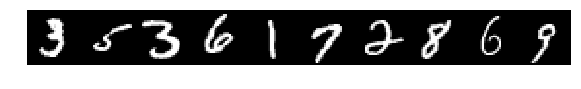

In [32]:
Image(Tensor(np.concatenate(x[10:20],2))).show(figsize=(10,1))

At this point in my old notebook, I set `y=x` and split them both into training and validation sets, but as we'll see, that's been automated in this version of fast.ai.

# Formatting data for fast.ai

Up till now we've just used pandas and numpy, but now I have to get into the nitty gritty of fast.ai's new `data_block` API.  The version used in the online course used `Dataset` objects which could be used to create `DataLoader` objects, which could then get wrapped into `ModelData` objects and used with a model to build a `Learner`.

`Dataset` and `DataLoader` objects are still in the underlying PyTorch framework, but they have been abstracted in the new version using `ItemLists`, which is like a more intuitive and flexible `Dataset`, and `Databunch`, which acts much like the old `ModelData` object, but works for more applications.  

I actually found myself writing something with some of the functionality of an `ItemList` in one of my projects so I'm not surprised to something like it eventually became part of the library.  For our purposes an `ItemList` is a `numpy.ndarray` of objects, with all the nice slicing functionality that entails, and methods that prepare the data your model will need to use.  The point is that directly storing your data in the array is often memory prohibitive, so instead for example you might store the filenames of images in your `ItemList` object `mydata` and then retrieve the tensor of pixel data only when `mydata.get` is called.  In fact this is the default behavior of the subclass `ImageItemList` used by the `fastai.vision` module.

Since I don't have the MNIST image files on disk, and the MNIST image data is relatively small, I've decided to store it directly.  It turns out that the `fastai.data_block` API is probably more suited to me just loading data out of the `train_df` `DataFrame` instance and reshaping it as needed, but trying to do it this way taught me quite a bit about how the API works.

First I want a custom class that has some of the functionality of `ImageItemList`, but pulls data directly from its `.items` property like `ItemList`, and is treated as regression data like a `FloatList`.

In [72]:
totensor = transforms.ToTensor()

In [73]:
def imread(fname):
    im = cv2.imread(str(fname))
    # openCV by default uses BGR ordering but we need RBG usually
    # height x width x channels
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [80]:
class ArraysImageItemList(ImageItemList,FloatList):
    def __init__(self, items:Iterator, log:bool=False, **kwargs):
        if isinstance(items, ItemList):
            items = items.items
        super(FloatList,self).__init__(items,**kwargs)
    
    def get(self,i):
        return Tensor(super(FloatList,self).get(i).astype('float32'))

In [81]:
x_il = VAEImageItemList(ItemList(img_paths))

In [86]:
x_il[0][0].shape

torch.Size([3, 512, 512])

In [40]:
len(x_il)

60000

In [44]:
from fastai.vision import ItemList

In [47]:
img_paths = list(p.iterdir())

In [41]:
class ArraysImageItemList(ImageImageList,FloatList):
    def __init__(self, items:Iterator, log:bool=False, **kwargs):
        if isinstance(items, ItemList):
            items = items.items
        super(FloatList,self).__init__(items,**kwargs)
    
    def get(self,i):
        return Tensor(super(FloatList,self).get(i).astype('float32'))

The next step is to split our data into training and validation (and optionally test) sets.  This is automated in the new version in a very nice way.

In [14]:
x_ils = x_il.random_split_by_pct()

Now we add labels to form a `LabelLists`.  Since our desired output is the same as our inputs, we will pass the training and validation sets in our `ItemLists` class as our training and validation labels.

In [15]:
lls = x_ils.label_from_lists(x_ils.train, x_ils.valid)

To wrap up the data preparation we create a databunch.  Again the library can handle this automatically.

In [16]:
db = lls.databunch()

To be honest, my instinct was to pair the raw data with labels (desired output) in a `LabelList` before splitting into training and validation sets.  The API appeared to support it, but I got a lot of unexpected behavior.  I later learned the preferred method is to split *then* pair with labels as you see above.  This seems less natural to me, as you have to take steps to ensure the training and validation inputs stay matched with training and validation outputs, but it may just take some getting used to on my part.  It certainly didn't turn out to be an issue in this application.

# Build model

## Encoder using ResNET34

[ResNET](https://arxiv.org/abs/1512.03385) is a deep learning architecture developed for image classification, specifically performance on the [ImageNet](http://www.image-net.org/) dataset.  This might be overkill, but I created the encoder with a ResNET34 spine (all layers except those specific to classification) pretrained on ImageNet.  These resources are available, free, and easy to access using fast.ai, so why not use them?

In [17]:
m = vision.models.resnet34(pretrained = True).cuda()

The idea behind using pretrained ResNET is that it's a network that already "knows" how to recognize images, and part of that skill is recognizing the important features that distinguish the types of images that humans are interested in.  We hope to leverage this ability to create a code layer that captures enough of the important information about handwritten digits that the digits can be reconstructed.  This technique of taking a network that performs well on one task and repurposing it to another task is called [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning).

I want to strip off the layers of ResNET that are more suited to classification, leaving the layers that gather and filter information about images.

There is probably a built-in way to do this, but since the structure of fast.ai has changed, I'm not sure where to look, so I get into the guts of the network.

In [18]:
m = nn.Sequential(*list(m.children())[:-3])

When building a custom model, I like to have a test vector on which to operate to make sure inputs and outputs are the right shape.

In [19]:
t,_ = next(iter(db.dl()))

In [20]:
t.size()

torch.Size([64, 3, 28, 28])

After looking at the data tensor this should make some sense.  The width of the first dimension has changed because our autoencoder will be training on batches of 64 images at once rather than the entire dataset or single images.

In [21]:
m(t).size()

torch.Size([64, 256, 2, 2])

We can see our ResNET encoder is changing the tensor shape.  The first dimension still corresponds with a 64-item batch of data, but the remaining dimensions don't correspond with color channels and image size anymore.  This is to be expected in deep neural networks, each successive layer abstracts the data away from the typology of the input.

At this point the output of the encoder is a tensor containing 1024 floats per image in a batch.  From a certain point of view, this makes the autoencoder's task very easy, particularly since the input was only 784 floats!  The point of an autoencoder isn't just to copy the image data to a different format, it's to efficiently encode the essence of the data.  Therefore, we're going to add a layer that cuts down the storage space the encoded image occupies and see how well it can reconstruct the original.

In [22]:
code_sz = 32

conv = nn.Conv2d(256, code_sz, kernel_size=(2,2)).cuda()

m.add_module('CodeIn',conv)

In [23]:
m(t).size()

torch.Size([64, 32, 1, 1])

The above is what our encoded layer looks like.  Now it can only use 32 floats per image for encoding.

## Decoder

We'll construct a decoder manually.  Essentially we'll upsample several times until we get to our original size.

In more detail, for each upsample we scale the resolution up, then do a trainable 2-d convolution (to allow our network to make changes), and then either a ReLU followed by a batchnorm or a sigmoid.  The idea is to use the sigmoid only on the output layer of the decoder.

In [24]:
class UpSample(nn.Module):
    def __init__(self,feat_in,feat_out,out_shape=None,scale=2):
        super().__init__()
        self.conv = nn.Conv2d(feat_in,feat_out,kernel_size=(3,3),stride=1,padding=1)
        self.out_shape,self.scale = out_shape,scale
        
    
    def forward(self,x):
        return self.conv(
            nn.functional.interpolate(
                x,size=self.out_shape,scale_factor=self.scale,mode='bilinear',align_corners=True))
        

In [25]:
def get_upSamp(feat_in,feat_out, out_shape=None, scale=2, act='relu'):
    
    upSamp = UpSample(feat_in,feat_out,out_shape=out_shape,scale=scale).cuda()
    
    layer = nn.Sequential(upSamp)
    
    if act == 'relu':
        act_f = nn.ReLU(inplace=True).cuda()
        bn = nn.BatchNorm2d(feat_out).cuda()
        layer.add_module('ReLU',act_f)
        layer.add_module('BN',bn)
    elif act == 'sig':
        act_f = nn.Sigmoid()
        layer.add_module('Sigmoid',act_f)
    return layer

def add_layer(m,feat_in,feat_out,name,out_shape=None,scale=2,act='relu'):
    upSamp = get_upSamp(feat_in,feat_out,out_shape=out_shape,scale=scale,act=act)
    m.add_module(name,upSamp)

I piece this together carefully, making sure the model layers match up at each stage.

In [26]:
add_layer(m,code_sz,256,'CodeOut')

In [27]:
m(t).size()

torch.Size([64, 256, 2, 2])

In [28]:
add_layer(m,256,128,'Upsample0')

In [29]:
m(t).size()

torch.Size([64, 128, 4, 4])

It take a bit of fiddling to end with the exact resolution we want.  It turns out that if we double the resolution in all the layers except this one, and in this one upsample from $4\times 4$ to $7\times 7$, then we end up exactly at $28\times 28$.

In [30]:
add_layer(m,128,64,'Upsample1',out_shape=(7,7),scale=None)

In [31]:
m(t).size()

torch.Size([64, 64, 7, 7])

In [32]:
add_layer(m,64,32,'Upsample2')

In [33]:
m(t).size()

torch.Size([64, 32, 14, 14])

In [34]:
add_layer(m,32,3,'Upsample3',act='sig')

In [35]:
m(t).size(), t.size()

(torch.Size([64, 3, 28, 28]), torch.Size([64, 3, 28, 28]))

Our autoencoder is at least outputting objects of the correct shape.

# Make learner and choose learning rate

The API for creating a learner is slightly different than the old version of fast.ai, with the databunch taking the place of `ModelData`.  Calling the `Learner` constructor (from basic_train.py) seems to be the new preferred way to get a learner, where before very often you were calling a `ConvLearner` class function.  We'll pass the `Learner` our data, model, and a loss function, mean squared error.

In [36]:
learn = Learner(db,m,loss_func=F.mse_loss)

`lr_find` is much the same as in the past, but the feedback makes it less opaque how to view the results.

In [37]:
learn.lr_find(end_lr=10000000)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


`learn.sched.plot()` has become `learn.recorder.plot()`.

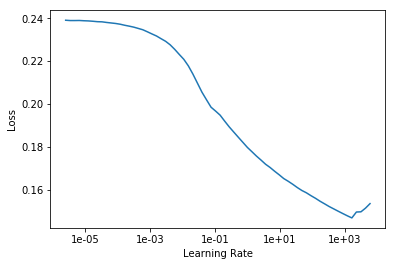

In [38]:
learn.recorder.plot()

The learning rate finder makes it easier to tune the learning rate hyper-parameter.  The graph shows us how the loss was reacting as `lr_find` dialed up the rate.  We see how far to the right on the graph we can go with the graph still maintaining a nice downward slope.  In my experience this tool is a little less straightforward when applied to autoencoders, so I'm going to be more conservative with the learning rate than the results indicate.

In [39]:
lr = 1e-2

# Training

`learn.fit` is still available as in the older version of fast.ai, but speedy one-cycle training has been wrapped up in `learn.fit_one_cycle`.  I presume the default parameters are good enough, and we'll train 10 epochs at our chosen learning rate.  

In [40]:
learn.fit_one_cycle(10,lr)

Total time: 05:26
epoch  train_loss  valid_loss
1      0.029886    0.034794    (00:32)
2      0.020761    0.021025    (00:32)
3      0.016994    0.017409    (00:32)
4      0.013616    0.017529    (00:32)
5      0.011100    0.011157    (00:32)
6      0.009833    0.011554    (00:32)
7      0.008426    0.007831    (00:32)
8      0.007405    0.006916    (00:33)
9      0.006586    0.006059    (00:32)
10     0.006256    0.005948    (00:32)



# View results

I love the built-in functions that are available now!  The results can be seen by calling `learn.show_results()`.

We can see the autoencoder output is slightly different from the input, but overall I'm pretty satisfied.

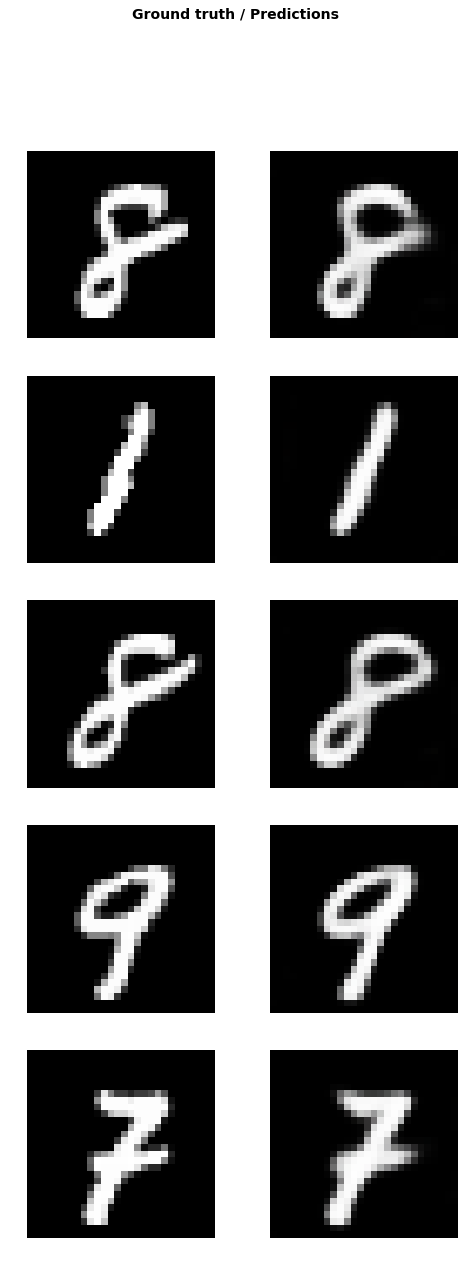

In [41]:
learn.show_results()

# How could we improve this?

We might be able to train the network faster or better if we were using [pixelshuffle](https://arxiv.org/abs/1609.05158) for upscaling.  At a high level, it's apparently a good idea to train the encoder to optimize the code layer rather than the final product (this bears more explanation but I'm not sure I'm equipped to say more, and it's outside the scope of this post).  If we had a more concrete goal for the autoencoder, we could regularize it for sparsity, small gradients, or resilience against noise as described in this [chapter](https://www.deeplearningbook.org/contents/autoencoders.html) of the [free textbook](https://www.deeplearningbook.org/) by Goodfellow, Bengio, and Courville.

That's all for now.  If you'd like to try out this notebook, you can download it <a href="https://alanbertl.com/wp-content/uploads/2018/12/MNIST-autoencoder.ipynb" download>here</a>.  You'll need [Jupyter](https://jupyter.org/).

Thanks for reading!